# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, avg, count
from pyspark.ml.feature import RegexTokenizer, CountVectorizer, IDF, StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, NaiveBayes, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import datetime
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master('local') \
    .appName('Sparkify') \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
sparkify_data = 'mini_sparkify_event_data.json'
data = spark.read.json(sparkify_data)

In [4]:
#Checking Database Schema
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
#Visualizing the first 5 records
data.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [6]:
#Number of records present
data.count()

286500

### Analysing Different rows for missing values

In [7]:
data.describe('userId').show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



In [8]:
data.describe('sessionId').show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [9]:
data_valid = data.dropna(how='any', subset=['userId', 'sessionId'])

In [10]:
data.select('userId').dropDuplicates().sort('userId').show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [11]:
#Removing whitespace in UserID
data_valid = data_valid.filter(data_valid.userId != '')

In [12]:
#Dataset remaining 
data_valid.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [13]:
#Pages in Sparkify app
data_valid.select('page').dropDuplicates().sort('page').collect()

[Row(page='About'),
 Row(page='Add Friend'),
 Row(page='Add to Playlist'),
 Row(page='Cancel'),
 Row(page='Cancellation Confirmation'),
 Row(page='Downgrade'),
 Row(page='Error'),
 Row(page='Help'),
 Row(page='Home'),
 Row(page='Logout'),
 Row(page='NextSong'),
 Row(page='Roll Advert'),
 Row(page='Save Settings'),
 Row(page='Settings'),
 Row(page='Submit Downgrade'),
 Row(page='Submit Upgrade'),
 Row(page='Thumbs Down'),
 Row(page='Thumbs Up'),
 Row(page='Upgrade')]

In [14]:
#Finding users who cancelled accounts
user_churn = data_valid.filter(data_valid.page == 'Cancellation Confirmation').select('userId').dropDuplicates()
user_churn_list = [(row['userId']) for row in user_churn.collect()]

In [15]:
print('{} Users Cancelled Accounts'.format(len(user_churn_list)))

52 Users Cancelled Accounts


In [16]:
#Add a new column named Churn to the data set
data = data_valid.withColumn('Churn', data_valid.userId.isin(user_churn_list).cast('int'))

In [17]:
data.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', Churn=0)]

In [18]:
#Find out the average number of ad clicks  
avg_count_true = data.filter("page == 'Roll Advert' AND Churn == 1").groupby(data.userId).count().agg(avg('count').alias('avg_count_true'))
avg_count_true = avg_count_true.toPandas()
avg_count_false = data.filter("page == 'Roll Advert' AND Churn == 0").groupby(data.userId).count().agg(avg('count').alias('avg_count_false'))
avg_count_false = avg_count_false.toPandas()
avg_count = pd.concat([avg_count_true, avg_count_false], axis=0, ignore_index=True, sort=False)
avg_count.index = ['True', 'False']
avg_count

,avg_count_true,avg_count_false
True,19.34,NaN
False,NaN,18.89172


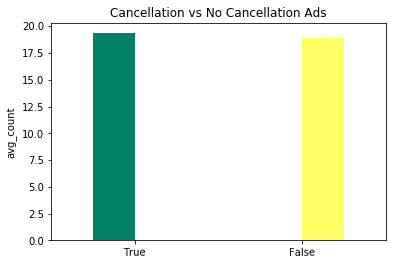

In [19]:
#Comparing the amount of clicked advertisements per person
avg_count.plot.bar(title='Cancellation vs No Cancellation Ads',legend=False,colormap='summer',rot=True)
plt.ylabel('avg_count');

In [20]:
#Find out the average number of songs played
avg_count_true_songs_played = data.filter("page == 'NextSong' AND Churn == 1").groupby(data.userId).count().agg(avg('count').alias('avg_count_true'))
avg_count_true_songs_played = avg_count_true_songs_played.toPandas()
avg_count_false_songs_played = data.filter("page == 'NextSong' AND Churn == 0").groupby(data.userId).count().agg(avg('count').alias('avg_count_false'))
avg_count_false_songs_played = avg_count_false_songs_played.toPandas()
avg_count_songs = pd.concat([avg_count_true_songs_played, avg_count_false_songs_played], axis=0, ignore_index=True, sort=False)
avg_count_songs.index = ['True', 'False']
avg_count

,avg_count_true,avg_count_false
True,19.34,NaN
False,NaN,18.89172


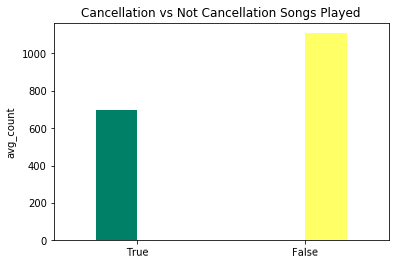

In [21]:
#Comparing the average number of songs played per person
avg_count_songs.plot.bar(title='Cancellation vs Not Cancellation Songs Played', legend=False,rot=True,colormap='summer')
plt.ylabel('avg_count');

In [22]:
#Find out the average number of visits in Help page
avg_count_true_help = data.filter("page == 'Help' AND Churn == 1").groupby(data.userId).count().agg(avg('count').alias('avg_count_true'))
avg_count_true_help = avg_count_true_help.toPandas()
avg_count_false_help = data.filter("page == 'Help' AND Churn == 0").groupby(data.userId).count().agg(avg('count').alias('avg_count_false'))
avg_count_false_help = avg_count_false_help.toPandas()
avg_count_help = pd.concat([avg_count_true_help, avg_count_false_help], axis=0, ignore_index=True, sort=False)
avg_count_help.index = ['True', 'False']
avg_count_help

,avg_count_true,avg_count_false
True,5.55814,NaN
False,NaN,8.154362


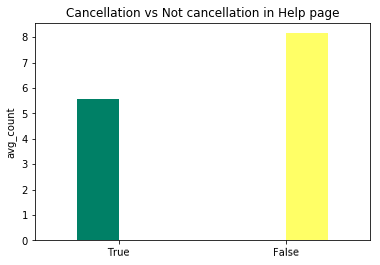

In [23]:
#Comparing the average number of visits in Help page
avg_count_help.plot.bar(title='Cancellation vs Not cancellation in Help page', legend=False, rot=True,colormap='summer')
plt.ylabel('avg_count');

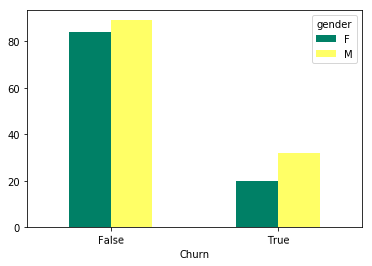

In [24]:
#Comapring gender with churn
gender = data.dropDuplicates(['userId']).groupby(['Churn', 'gender']).count()
gender = gender.toPandas()
gender.Churn = gender.Churn.replace([1, 0], ['True', 'False'])
pd.DataFrame(pd.pivot_table(gender, index='Churn', columns='gender', values='count')).plot.bar(rot=True,colormap='summer')

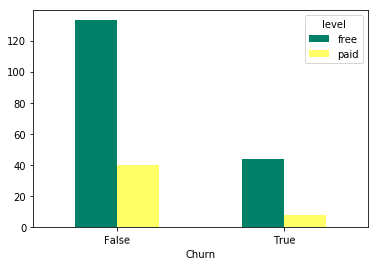

In [25]:
#Comparing free/paid status with churn
level = data.dropDuplicates(['userId']).groupby(['Churn', 'level']).count()
level = level.toPandas()
level.Churn = level.Churn.replace([1, 0], ['True', 'False'])
pd.DataFrame(pd.pivot_table(level, index='Churn', columns='level', values='count')).plot.bar(rot=True,colormap='summer')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [26]:
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- Churn: integer (nullable = true)



In [27]:
#Coverting categorical values to binary
data = data.replace(['F', 'M'], ['0', '1'], 'gender')
data = data.replace(['free', 'paid'], ['0', '1'], 'level')
data = data.withColumn('gender', data.gender.cast('int'))
data = data.withColumn('level', data.level.cast('int'))

In [28]:
#Add feature Help to calculate how many Help pages each user clicked
data_help = data.filter(data.page == 'Help').groupby('userId').agg(count('page').alias('Help')).select(['userId', 'Help'])
data = data.join(data_help, 'userId')

In [29]:
#Add feature Songs to calculate how many songs each user listened to
data_songs = data.filter(data.page == 'NextSong').groupby('userId').agg(count('page').alias('Songs')).select(['userId', 'Songs'])
data = data.join(data_songs, 'userId')

In [30]:
#Add feature Ads to calculate how many ads each user clicked
data_ads = data.filter(data.page == 'Roll Advert').groupby('userId').agg(count('page').alias('Ads')).select(['userId', 'Ads'])
data = data.join(data_ads, 'userId')

In [31]:
data.printSchema()

root
 |-- userId: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: integer (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: integer (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- Churn: integer (nullable = true)
 |-- Help: long (nullable = false)
 |-- Songs: long (nullable = false)
 |-- Ads: long (nullable = false)



In [32]:
data.head()

Row(userId='100010', artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender=0, itemInSession=0, lastName='Carpenter', length=202.97098, level=0, location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', Churn=0, Help=2, Songs=275, Ads=52)

In [33]:
#Dataset used for training model
data_model = data.select(['userId', 'Ads', 'Songs', 'Help', 'level', 'gender', 'Churn'])

In [34]:
data_model.printSchema()

root
 |-- userId: string (nullable = true)
 |-- Ads: long (nullable = false)
 |-- Songs: long (nullable = false)
 |-- Help: long (nullable = false)
 |-- level: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- Churn: integer (nullable = true)



In [35]:
data_model.head()

Row(userId='100010', Ads=52, Songs=275, Help=2, level=0, gender=0, Churn=0)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [36]:
#Splitting data into train and test set
train, test = data_model.randomSplit([0.8, 0.2], seed=42)

In [37]:
#Pipeline Stages
assembler = VectorAssembler(inputCols=data_model.columns[1:6], outputCol='FeaturesVector')
scaler = StandardScaler(inputCol='FeaturesVector', outputCol='features', withStd=True, withMean=True)
indexer = StringIndexer(inputCol='Churn', outputCol='label')

In [38]:
#Creating logistic regression pipeline
lr = LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)
pipeline = Pipeline(stages=[assembler, scaler, indexer, lr])

In [39]:
#Setting parametets
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0, 0.2]) \
    .addGrid(lr.maxIter, [10, 20]) \
    .addGrid(lr.threshold, [0.44, 0.46]) \
    .build()

#Crossvalidation
crossval_lr = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [40]:
#Training logistic regression model
model_lr = crossval_lr.fit(train)

In [41]:
model_lr.avgMetrics

[0.7846396416057526,
 0.7812815847428474,
 0.7840716158070482,
 0.7812815847428474,
 0.7724723874499535,
 0.7724723874499535,
 0.7724723874499535,
 0.7724723874499535]

In [42]:
#Predciting on test set
results_lr = model_lr.transform(test)

In [43]:
#Get F1 score
MulticlassClassificationEvaluator(metricName='f1').evaluate(results_lr)

0.7807969583843655

In [44]:
results_lr.select('prediction').dropDuplicates().collect()

[Row(prediction=0.0), Row(prediction=1.0)]

The first prediction parameter is only regParam, and the result labels are all 0. The second time I added too many parameters and it was too slow, so I reduced it, but the result was still 0. The third time, I think there might be a problem with the threshold value. The default is 0.5. I adjusted it down a bit and tried it, but the adjustment was too low, which resulted in overfitting the results. Finally, after adjusting to the appropriate parameters, the result was better.

In [45]:
#Creating the random forest pipeline
rf = RandomForestClassifier(numTrees=5, maxDepth=3, seed=30)
pipeline = Pipeline(stages=[assembler, scaler, indexer, rf])

In [46]:
#Setting parameters
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [5, 10]) \
    .addGrid(rf.minInstancesPerNode, [1, 3]) \
    .addGrid(rf.maxDepth, [3, 7]) \
    .addGrid(rf.minInfoGain, [0, 1]) \
    .build()

#Crossvalidation
crossval_rf = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [47]:
#Training random forest model
model_rf = crossval_rf.fit(train)

In [48]:
model_rf.avgMetrics

[0.7847751465178989,
 0.7724723874499535,
 0.9322419410209905,
 0.7724723874499535,
 0.7847751465178989,
 0.7724723874499535,
 0.9322419410209905,
 0.7724723874499535,
 0.8094186876123541,
 0.7724723874499535,
 0.9288514330093214,
 0.7724723874499535,
 0.8094186876123541,
 0.7724723874499535,
 0.9288514330093214,
 0.7724723874499535]

In [49]:
#Predciting on test set
results_rf = model_rf.transform(test)

In [50]:
#Get F1 score
MulticlassClassificationEvaluator(metricName='f1').evaluate(results_rf)

0.9087860053077775

In [51]:
results_rf.select('prediction').dropDuplicates().collect()

[Row(prediction=0.0), Row(prediction=1.0)]

In [52]:
result_rf = results_rf.select(['label', 'prediction']).toPandas()

In [53]:
result_rf.count()

label         52182
prediction    52182
dtype: int64

In [54]:
result_rf[result_rf['label'] == result_rf['prediction']].count()

label         48022
prediction    48022
dtype: int64

Too many parameters were added for the first time: numTrees, minInstancesPerNode, maxDepth, minInfoGain, and the amount of parameters was large, which caused the model to run too slowly. Then I canceled a minInfoGain parameter, but the result label of the second time was all 0, so I adjusted the parameter name as the first time, but adjusted the minInfoGain to 0 and 1 respectively, and minInstancesPerNode to 1 and 1 respectively. 3. I adjusted the numTrees and maxDepth separately to make the model run faster, and the results were pretty good.

In [55]:
metric = model_rf.avgMetrics
best_index = metric.index(max(metric))
best_param = model_rf.getEstimatorParamMaps()[best_index]
print('The best model is the random forest classifier model, and the best parameters are：')
for name, score in best_param.items():
    print('{}:{}'.format(name.name, score))

The best model is the random forest classifier model, and the best parameters are：
numTrees:5
minInstancesPerNode:1
maxDepth:7
minInfoGain:0.0


## Results discussion

The problem in this project is to predict the loss of users, which is a binary classification prediction problem, so the selected model will fit this feature. I used the random forest classifier and logistic regression classifier The best effect is the random forest classifier. The F1 score is 0.91. First, I cleaned the data set, and then explored the data set using EDA. I used Feature engineering, and finally build a machine learning model to predict. The random forest classifier is specifically used to solve classification and regression problems, and can handle both classification and numerical features and has strong resistance to overfitting. I think this is also a manifestation of good performance in both the training set and the test set. However, more accuracy can be achieved by running the model on the original dataset, which is 12GB in size. It will require AWS/IBMCloud or other providers. Running models on this machine is limited by hardware, and adjusting parameters becomes more difficult. If these aspects can be improved, I think the result will be better.

## Difficulties and Challenges

There are many algorithms that can be used when building the model. But after I tested a lot of models, I found that some models have errors that are difficult to solve. For example, when I use the NaiveBayes model, I have a complex error. It is difficult to find a solution, which is related to the software version number. At this time, it is necessary to change a model. In addition, when adjusting the parameters, the initial parameters caused the training to be very slow. Later, after searching and in-depth understanding of each parameter on the Internet, it was difficult to optimize the parameters. This step is more difficult because it involves time costs. Also, when visualizing, I need to convert the columns of a pandas data frame into rows and then directly into the histogram I want.

## Reflection

When I used a bar chart to compare the per-user help page clicks of users, I found something interesting. The results show that the churn user's per capita help clicks are much less than those of non-churn users. I started telling me that the fewer clicks on the help page should mean that the fewer problems you encounter, the better the software experience. Then why is there less user clicks than retained users? I thought about it carefully. It may because the churn users found the help page confusing. 

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.